In [1]:
import sys
sys.path.append("/opt/CRPropa3/lib/python3.8/site-packages")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import crpropa

from fancy import Data, Analysis, Model

In [3]:
# import uhecr data from uhecr file

uhecr_file = "../data/UHECRdata.h5"
detector_type = "TA2015"

'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, Eth
else:
    raise Exception("Undefined detector type!")


# construct Dataset
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)

# get uhecr detected arrival direction and detected energy
uhecr_coord = data.uhecr.coord
uhecr_energy = data.uhecr.energy

# get lon and lat arrays for future reference
# shift lons by 180. due to how its defined in mpl
uhecr_lons = np.pi - uhecr_coord.galactic.l.rad
uhecr_lats = uhecr_coord.galactic.b.rad

# number of uhecrs
N_uhecr = len(uhecr_coord)

# also get reconstruction uncertainties
arr_dir_unc = np.deg2rad(data.detector.coord_uncertainty)

In [4]:
# convert SkyCoord -> crpropa.Vector3d() to use with CRPropa
# coord is in galactic frame, lon and lat
# Angle definitions:
# CRPropa uses
#   longitude (phi) [-pi, pi] with 0 pointing in x-direction
#   colatitude (theta) [0, pi] with 0 pointing in z-direction
# matplotlib expects
#   longitude [-pi, pi] with 0 = 0 degrees
#   latitude [pi/2, -pi/2] with pi/2 = 90 degrees (north)
# SkyCoord uses:
#   lon: [0, 2pi]
#   lat: [-pi/2, pi/2]
uhecr_vector3d = []
for i, coord in enumerate(uhecr_coord):
    v = crpropa.Vector3d() 
    v.setRThetaPhi(1, np.pi / 2. - coord.galactic.b.rad, np.pi - coord.galactic.l.rad)
    uhecr_vector3d.append(v)

In [17]:
# set up CRPropa simulation and initialize objects
sim = crpropa.ModuleList()

# setup magnetic field
gmf = crpropa.JF12Field()
seed = 691342
gmf.randomStriated(seed)
gmf.randomTurbulent(seed)

# Propagation model, parameters: (B-field model, target error, min step, max step)
sim.add(crpropa.PropagationCK(gmf, 1e-4, 0.1 * crpropa.parsec, 100 * crpropa.parsec))
obs = crpropa.Observer()

# observer at galactic boundary (20 kpc)
obs.add(crpropa.ObserverSurface( crpropa.Sphere(crpropa.Vector3d(0), 20 * crpropa.kpc) ))
# obs.onDetection(TextOutput('galactic_backtracking.txt', Output.Event3D))
sim.add(obs)
print(sim)


# composition, assume proton for now
# - nucleusId(A, Z)
pid = - crpropa.nucleusId(1,1)
# pid = - crpropa.nucleusId(28, 14)

# CRPropa random number generator
crpropa_randgen = crpropa.Random() 

# position of earth in galactic coordinates
pos_earth = crpropa.Vector3d(-8.5, 0, 0) * crpropa.kpc

ModuleList
  Propagation in magnetic fields using the Cash-Karp method. Target error: 0.0001, Minimum Step: 0.0001 kpc, Maximum Step: 0.1 kpc
  Observer
    ObserverSurface: << Sphere: 
   Center: 0 0 0
   Radius: 6.17136e+20

    Flag: '' -> ''
    MakeInactive: yes




In [18]:
# obtain random directions based on reconstruction uncertainty

Nrand = 100

rand_arrdirs = np.zeros((N_uhecr, Nrand, 2))
defl_lons = np.zeros((N_uhecr, Nrand))
defl_lats = np.zeros((N_uhecr, Nrand))

# cos(theta), dot product
cos_thetas = np.zeros((N_uhecr, Nrand))

for i, arr_dir in enumerate(uhecr_vector3d):
    energy = uhecr_energy[i] * crpropa.EeV
    for j in range(Nrand):
        rand_arrdir = crpropa_randgen.randVectorAroundMean(arr_dir, arr_dir_unc)

        c = crpropa.Candidate(crpropa.ParticleState(pid, energy, pos_earth, rand_arrdir))
        sim.run(c)

        defl_dir = c.current.getDirection()

        # append longitudes and latitudes
        # need to append np.pi / 2 - theta for latitude
        # also append the randomized arrival direction in lons and lats
        rand_arrdirs[i, j, :] = rand_arrdir.getPhi(), np.pi / 2. - rand_arrdir.getTheta()
        defl_lons[i, j] = defl_dir.getPhi()
        defl_lats[i, j] = np.pi / 2. - defl_dir.getTheta()

        # evaluate dot product between arrival direction (randomized) and deflected vector
        # dot exists with Vector3d() objects
        cos_theta = rand_arrdir.dot(defl_dir)
        cos_thetas[i, j] = cos_theta




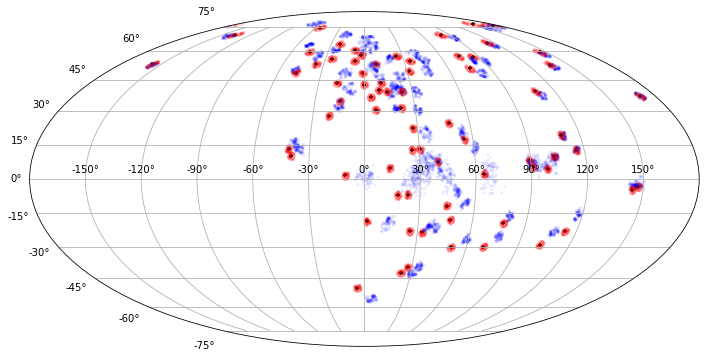

In [19]:
# check with basic mpl mollweide projection
plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection = 'mollweide')

ax.scatter(uhecr_lons, uhecr_lats, color="k", marker="+", s=10.0, alpha=1., label="True")
for i in range(N_uhecr):
    ax.scatter(defl_lons[i, :], defl_lats[i, :], color="b", alpha=0.05, s=4.0)
    ax.scatter(rand_arrdirs[i, :, 0], rand_arrdirs[i, :, 1], color="r", alpha=0.05, s=4.0)
# ax.scatter(defl_lons[1, :], defl_lats[1, :])
ax.grid()

In [20]:
'''Distributions of interest'''

def fischer(kappa, cos_thetaP):
    '''vMF distribution'''
    return (kappa * np.exp(kappa * cos_thetaP)) / (4.*np.pi * np.sinh(kappa))

def fischer_int(kappa, cos_thetaP):
    '''Integral of vMF function over all angles'''
    return (1. - np.exp(-kappa * (1 - cos_thetaP))) / (1. - np.exp(-2.*kappa))

def fischer_int_eq_P(kappa, cos_thetaP, P):
    '''Equation to find roots for'''
    return fischer_int(kappa, cos_thetaP) - P

def log_fischer(kappa, cos_thetaP):
    '''vMF distribution in log scale (base e)'''
    return np.log(kappa) - np.log(2*np.pi) - kappa * (1 - cos_thetaP)


In [21]:
# evaluate kappa_d from scalar product
# how this works is shown in solve_kappad.ipynb
from scipy.optimize import root
import h5py

kappa_ds = np.zeros((N_uhecr, Nrand))

P = 0.683  # as defined in Soiaporn paper

for (i, j), cos_theta in np.ndenumerate(cos_thetas):
    sol = root(fischer_int_eq_P, x0=1, args=(cos_theta, P))
    # print(sol)   # check solution

    kappa_sol = sol.x[0]
    kappa_ds[i, j] = kappa_sol

    # print("kappa = ", kappa_sol)

# evaluate mean kappa for each uhecr
kappa_d_mean = np.mean(kappa_ds, axis=1)

# store into h5py file with uhecr data
# since this only changes with different uhecr
# with h5py.File(uhecr_file, "r+") as f:
#     uhecr_group = f[detector_type]
#     uhecr_group["kappa_d"][()] = kappa_d_mean
    # uhecr_group.create_dataset("kappa_d", data=kappa_d_mean)

In [22]:
# check if we have written kappa_d correctly
# with h5py.File(uhecr_file, "r+") as f:
#     print(f[detector_type]["kappa_d"][()])

print(kappa_d_mean)

[   72.43882124    63.92144619  3641.19628655  4596.67421812
 14808.88869692  2110.20850004  7585.06352044   484.54615246
   348.70722161   324.51874803   144.85607653   215.07723316
   131.50595223  3034.70397613   208.19715037   177.57154435
   117.74334251    37.02362191   878.89260332  3207.74919713
 14248.04971845  1166.95719174   158.27820599   125.72469962
    46.91063366    76.67762052    65.63879957    59.79154624
    79.05607345    74.90324954 11252.62844282   212.82668876
   307.73232802   108.41519598   470.85508164   158.25374841
   130.18757512  5480.1163824    128.49750038  9693.44762552
  2455.07160086    90.53458722   155.25718872   670.14343949
   185.98805151  1962.66379104   172.23318546   369.61096295
   207.09126313   343.53506386   114.56455512   323.1035905
   121.23738219  1184.06111881   134.48338248   150.35643541
   109.47835009  4777.85371848   186.17820347  2376.14359865
   159.61080654   276.71162581   106.43957106   536.90043897
   109.72797111   112.202